# TerraLoad
Welcome! This is a project that is supposed to explore the correlation between land elevation (topographic elevation) and gravity anomalies. I'll be adding more to this as time goes on. Hopefully I finish it!

**Grace Dataset**

D. N. Wiese, D.-N. Yuan, C. Boening, F. W. Landerer, M. M. Watkins. 2023. JPL GRACE and GRACE-FO Mascon Ocean, Ice, and Hydrology Equivalent Water Height CRI Filtered RL06.3Mv04. Ver. RL06.3Mv04. PO.DAAC, CA, USA. Dataset accessed [2025-05-28] at https://doi.org/10.5067/TEMSC-3JC634

**Teopography dataset**

NOAA National Centers for Environmental Information. 2022: ETOPO 2022 15 Arc-Second Global Relief Model. NOAA National Centers for Environmental Information. DOI: 10.25921/fd45-gt74. Accessed [6/1/2025].

In [ ]:
print('Hello World!')

## The sweet sweet math/physics
I'll start this off by going over the background math and physics. I learned all of this from Geophysics class, Geodynamics (2nd edition) by Donald L. Turcotte and Geral Schubert, and The Solid Earth (2nd edition) by C.M.R. Fowler.

### Gravity and Satellites

- **Gravity of the Earth**  
    The gravitational acceleration towards the Earth can be represented by:

    $$
    -a = \frac{GM_e}{r^2}
    $$

    Where:
    - $G$ is the gravitational constant.
    - $M_e$ is the mass of the Earth.
    - $r$ is the radius of the Earth.

    This is a nice representation if Earth were a perfect shape and stationaryy. But alas, it is neither of those things. First of all, the Earth is not a perfect sphere. It's more like an oblate spheroid. We can approximate this shape by taking an ellipse and revolving it around its minor axis...like so:

    $$
    f = \frac{R_e - R_p}{R_e}
    $$
    
    This is called ellipticity, or polar flattening, given by $f$, where:
    - $R_e$ is the equatorial radius.
    - $R_p$ is the polar radius.

    We can also describe the radius of an oblate spheroid as:

    $$
    r = R_e (1 - fsin^2 \lambda)
    $$

    Something interesting that happens with the Earth...is that it spins. I know, I know, it's not that impressive, but this does something neat with the gravity. Because the Earth is spinning, gravity on its surface is actually reduced due to Centrifugal Acceleration. On a sphere with an angular rotation frequency $\omega$, this turns out to be:

    $$
    g_{rot} = g - \omega^2 R_e cos^2 \lambda
    $$

    where:
    - $g$ is the gravity on a non-rotating sphere.
    - $\lambda$ is the lattitude.

    Remember that this is for a nice sphere. It's a bit trickier to approximate for an oblate spheroid. Luckily the International Association of Geodesy adopted the reference gravity formula, which says:

    $$
    g(\lambda) = g_e (1 + \alpha sin^2 \lambda + \beta sin^4 \lambda)
    $$

    Where:
    - $g_e$ is the equatorial gravitational acceleration (which is about 9.7803185 m/s^2)
    - $alpha$ is a constant accounting for the first-order effects on Earth's oblateness (like how gravity is stronger at the poles than at the equator). The numerical value is $\alpha = 5.278895 * 10^{-3}$
    - $\beta$ is a constant that accounts for higher-order oblateness, more along the lines of how rotation and ellipticity mess with gravity. The numerical value is $\beta = 2.3462 * 10^{-5}$

    This pretty much sets gravity as a function of lattitude, which depends on rotation, ellipticity, distance from the equator, and many other things. I shall do a derivation of this in its own subsection.

- **Basic Satellite Orbits**
    Since this project relies on satellite data, it'll be worthwhile to have atleast a basic grasp of the orbits of satellites around the Earth. I'll have it simplified for now...since I don't really have a great understanding of it myself. So, ltet's consider the gravity of the Earth acting on a tiny little satellite. Re-arranging our little equation for Earth's gravity from earlier, we get:

    $$
    \frac{G M_e m}{r^2} = m \omega^2 r
    $$

    Where Earth's gravity acting on the satellite is being balanced by the centrifugal force the satellite experiences while orbiting:
    - $m$ is the mass of the satellite.
    - $\omega$ is the angular velocity of the satellite.

    We can re-arrange this equation to solve for $\omega$:

    $$
    \omega = (\frac{G M_e}{r^3})^{1/2}
    $$

    This shows the angular velocity that a satellite needs to orbit comfortably around a perfectly spherical Earth.

In [3]:
from IPython.display import display, HTML

display(HTML(""" 
<div>
     <img src = "Assets/Satellite_orbit.gif" width = "700">
</div
"""))

**Satellite Ground Tracks**
As I've stated earlier, the datases used are the Gravity Recovery and Climate Experiment (GRACE) mission dataset and the ETOPO 2022 Global Relief Model. Below is a figure that shows a basic overview of the tracks of two sattelites, being GRACE and ICESat-2 (Ice, Cloud, and land Elevation Satellite - 2). I chose ICESat-2 because it was one of the contributing satellites to the ETOPO model. The figure is a basic simulation of their flight trajectories across the Earth, and is entirely meant as a basic visual guide.

- **GRACE**
    GRACE flies in a low polar orbit (485 km at launch on March 17th, 2002, and decayed to 382 km by September 2015). I used a sinusoidal curve to represent  how the satellite's path curves due to Earth's rotation.

- **ICESat-2**
    Follows a similarly shaped orbit.

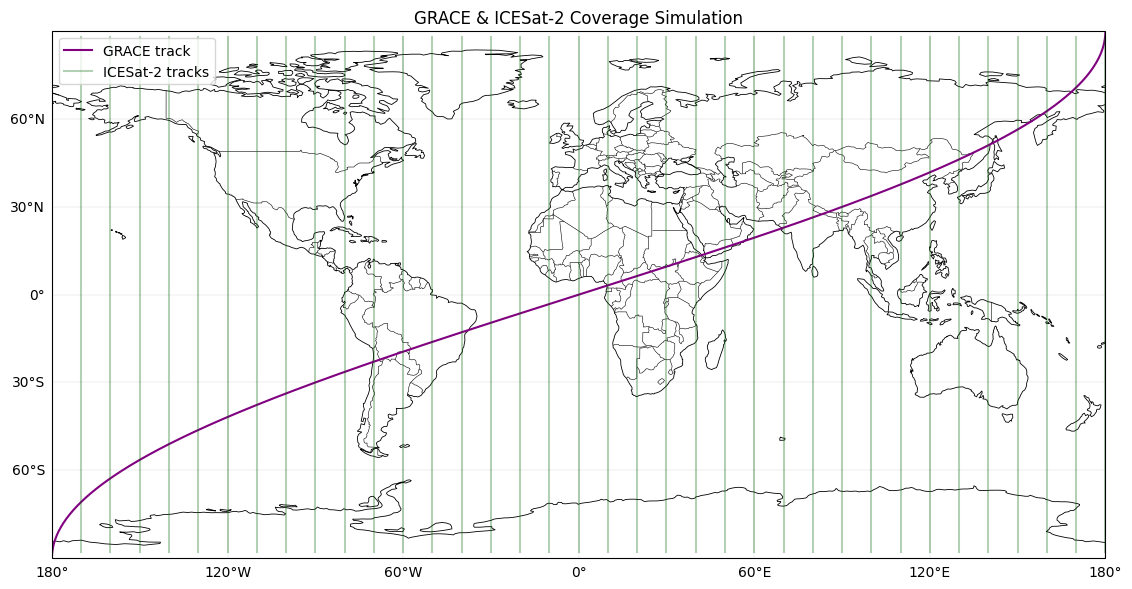

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Here I'm just visualizing satellite flight paths. The GRACE track is for the GRACE dataset, and the ICESat2 is for the ETOPO 2022 Global Relief Model Geoid Height dataset. I know ICESat2 wasn't the only sensor used, this is just for visualization purposes.

# Simulated GRACE track
GRACE_latitudes = np.linspace(-89.5, 89.5, 500)
GRACE_longitudes = np.mod(10 * np.sin(np.radians(GRACE_latitudes)) * 18 + 180, 360) - 180

# Simulated ICESat-2 tracks
ICESat2_longitudes = np.arange(-180, 181, 10)
ICESat2_latitudes = np.linspace(-88, 88, 500)

# Plot
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines(linewidth = 0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
gl = ax.gridlines(draw_labels = True, linewidth = 0.2, color = 'gray', alpha = 0.5)
gl.top_labels = gl.right_labels = False

# GRACE orbital track. It's not based off of orbit data, it's just a quick little simulation entirely to visualize where it is.
plt.plot(GRACE_longitudes, GRACE_latitudes, transform=ccrs.Geodetic(), color='purple', linewidth=1.5, label='GRACE track')

# ICESat-2 tracks. Again, it's only a basic simulation like GRACE.
for i, longitude in enumerate(ICESat2_longitudes):
    plt.plot([longitude] * len(ICESat2_latitudes), ICESat2_latitudes, transform = ccrs.Geodetic(), color = 'darkgreen', alpha = 0.3, linewidth = 1.5, label = 'ICESat-2 tracks' if i == 0 else None)

plt.title('GRACE & ICESat-2 Coverage Simulation')
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
from IPython.display import display, HTML
display(HTML("""
<div style = "display: flex; gap: 15px;">
    <div>
        <img src = "Assets/grace_lwe_animation.gif" width = "1000">
        <p style = "text - align: center;" > LWE Thickness</p>
    </div>
    <div>
        <img src = "Assets/LWE Gravity Change.gif" width = "1000">
        <p style = "text-align:center;">Gravity Anomaly</p>
    </div>
</div>
"""))

In [22]:
from IPython.display import display, HTML

display(HTML("""
<div style="display: flex;">
    <div>
        <img src="Assets/ETOPO_downsample.png" width="1000">
    </div>
</div>
"""))